<a href="https://colab.research.google.com/github/IsaacMrSmile/Alura_Bootcamp_Data_Science/blob/main/CNN_for_Petrography_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
%tensorflow_version 2.x
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import pathlib
from tensorflow import keras
from tensorflow.keras import models, layers, regularizers

In [ ]:
#Set global variables
batch_size = 5
img_height = 160
img_width = 160
data_dir = '/content/drive/MyDrive/Petrography Rec Datasets/Datasets'
data_dir = pathlib.Path(data_dir)

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

211


In [ ]:
#You might modify the input pipeline as needed
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [ ]:
#Take a look the directory
for f in list_ds.take(5):
  print(f.numpy())

b'/content/drive/MyDrive/Petrography Rec Datasets/Datasets/muscovite/mus11.jpg'
b'/content/drive/MyDrive/Petrography Rec Datasets/Datasets/muscovite/mus25.jpg'
b'/content/drive/MyDrive/Petrography Rec Datasets/Datasets/biotite/bio5.jpg'
b'/content/drive/MyDrive/Petrography Rec Datasets/Datasets/alkali_feldspar/afeld30.jpg'
b'/content/drive/MyDrive/Petrography Rec Datasets/Datasets/pyroxene/Py 9.jpg'


In [ ]:
#List of categories
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['alkali_feldspar' 'biotite' 'hornblende' 'muscovite' 'olivine'
 'plagioclase' 'pyroxene' 'quartz']


In [ ]:
#Split datasets into train and test data
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [ ]:
#The number of training and test data
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

169
42


In [ ]:
#Create small function to take image and label from datasets. Look more detail at tensorflow documentation

def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])
  
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [ ]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [ ]:
#Print shape and label of a image
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (160, 160, 3)
Label:  3


In [ ]:
#.cache() keeps the images in memory after they're loaded off disk during the first epoch
#.prefetch() overlaps data preprocessing and model execution while training.
#buffered prefetching so we can yield data from disk without having I/O become blocking (based on tensorflow documentation)

def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

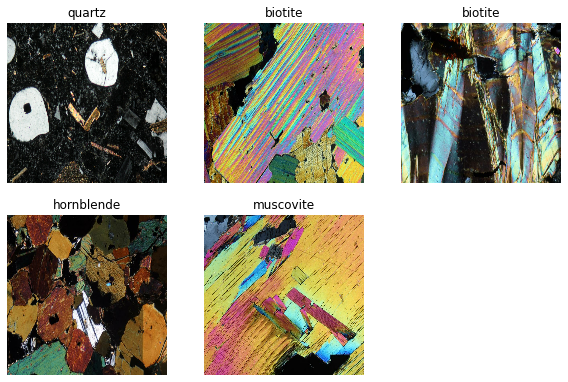

In [ ]:
#Show some pictures and its labels.

image_batch, label_batch = next(iter(train_ds)) #take image, label for trainining
val_image, val_labels = next(iter(val_ds)) #take image, label for validation

import matplotlib.pyplot as plt


plt.figure(figsize=(10, 10))
for i in range(5):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

In [ ]:
#Rescale to float between 0 and 1
rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255)
])

In [ ]:
#Data Augmentation
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(0.2, width_factor=0.2),
])

In [ ]:
#Create CNN Architecture (This is the simplest model)
model = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(160,160,3)),
  rescale,
  data_augmentation,
  
  layers.Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(0.01), activation='relu'),
  layers.MaxPooling2D(),
 
  layers.Dropout(0.5),

  layers.Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(0.01), activation='relu'),
  layers.MaxPooling2D(),

  layers.Dropout(0.5),

  layers.Flatten(),
  layers.Dense(32, activation ='relu'),
  layers.Dropout(0.5),
  layers.Dense(8, activation = 'relu')
])

In [ ]:
''' THIS MODEL BELOW HAS THE MOST LAYERS THAN THE PREVIOUS MODEL
model = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(160,160,3)),
  rescale,
  data_augmentation,

  layers.Conv2D(160, (3,3), activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Conv2D(80, (3, 3), activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Conv2D(60, (3, 3), activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Conv2D(30, (3, 3), activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten()
])
'''

In [ ]:
#Model Summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 160, 160, 3)       0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 160, 160, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 158, 158, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 79, 79, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 79, 79, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 77, 77, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 32)       

In [ ]:
#Compile the model and training process
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_ds, 
                    validation_data = val_ds, 
                    epochs=500)

Epoch 1/500
34/34 [==============================] - 8s 190ms/step - loss: 2.8368 - accuracy: 0.1598 - val_loss: 2.3666 - val_accuracy: 0.2143
Epoch 2/500
34/34 [==============================] - 6s 182ms/step - loss: 2.3477 - accuracy: 0.1598 - val_loss: 2.3111 - val_accuracy: 0.2143
Epoch 3/500
34/34 [==============================] - 6s 183ms/step - loss: 2.2859 - accuracy: 0.1361 - val_loss: 2.2693 - val_accuracy: 0.2381
Epoch 4/500
34/34 [==============================] - 6s 184ms/step - loss: 2.2579 - accuracy: 0.1479 - val_loss: 2.2454 - val_accuracy: 0.2143
Epoch 5/500
34/34 [==============================] - 6s 182ms/step - loss: 2.1966 - accuracy: 0.2071 - val_loss: 2.2169 - val_accuracy: 0.1190
Epoch 6/500
34/34 [==============================] - 6s 180ms/step - loss: 2.1990 - accuracy: 0.1598 - val_loss: 2.1965 - val_accuracy: 0.0714
Epoch 7/500
34/34 [==============================] - 6s 181ms/step - loss: 2.2061 - accuracy: 0.1716 - val_loss: 2.1933 - val_accuracy: 0.1905

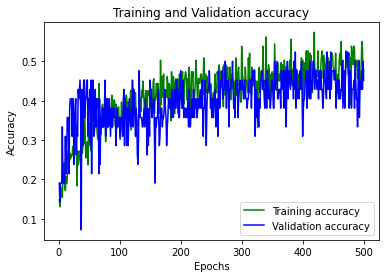

In [ ]:
#Train and val acc curve
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(loss)+1)
plt.plot(epochs, accuracy, 'g', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#I have tried this with epochs up to 1000 but the result is still overfitting

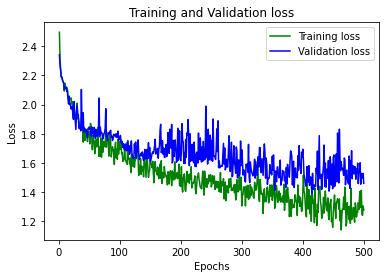

In [ ]:
#Training and validation loss curve
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()